## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_horizVert_wavelet_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/wavelet/horizVert/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

Running 12760 CDFs


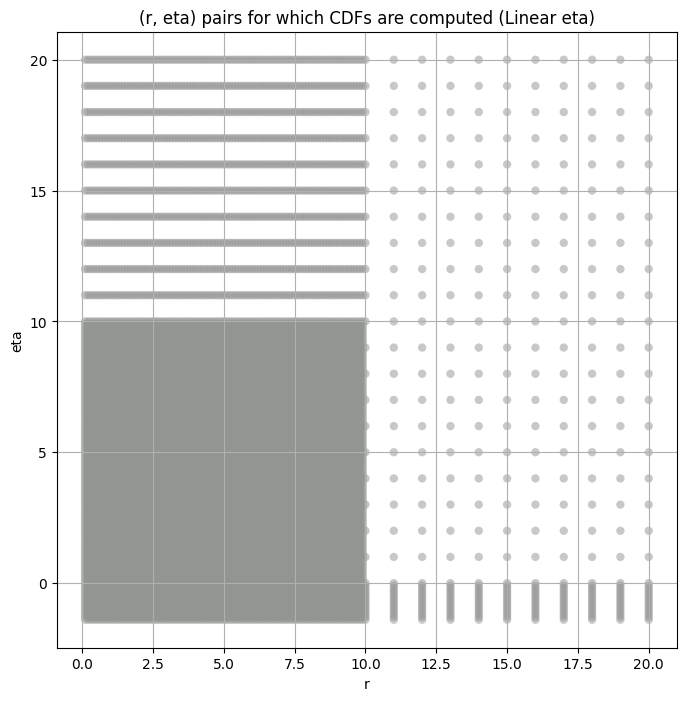

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2275.500700  2053.203900  2515.630100   2.985151    1.770765   
3       731.808500   692.460750   773.192600   2.677345    2.022238   
4       204.856160   192.844450   217.289660   3.331176    2.626189   
5        47.329070    44.213856    50.590443   4.919961    3.891603   
6         9.356699     8.643291    10.108271   7.053292    5.380576   
7         1.714758     1.571090     1.868863   9.429799    7.182782   
8         0.261782     0.237458     0.290044  13.011990    8.738512   

       kurt_upper  total_samples  
layer                             
2        4.367098         3180.0  
3        3.451370        12720.0  
4        4.226743        50880.0  
5        6.230281       203520.0  
6        9.599891       814080.0  
7       13.313757      3256320.0  
8       28.509798     13025280.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      2275.500700    2275.500732     1812.548218     1590.067261   
3       731.808500     731.808472      674.567261      641.094910   
4       204.856160     204.856155      198.523712      194.387589   
5        47.329070      47.329071       46.259899       45.499836   
6         9.356699       9.356699        9.084558        8.906506   
7         1.714758       1.714758        1.656466        1.618210   
8         0.261782       0.261782        0.250605        0.243963   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         1422.716553      1289.374878      1088.114746       931.005920   
3          613.557739       589.786011       548.873718       515.292847   
4          190.825684       187.641434       181.950409       177.031967   
5           44.845467        44.262119        43.243435        42.351040   
6            8.755926         8.621597         8.386519         8.182270   
7            1.586136         1.557840         1.508510         1.465863   
8            0.238476         0.233676         0.225397         0.218273   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           803.395142       696.830078       607.145752       408.729767  
3           486.254089       460.521545       437.825409       381.221191  
4           172.578796       168.466110       164.647415       154.695084  
5            41.551979        40.814053        40.131401        38.307419  
6             7.998828         7.831634         7.677250         7.272254  
7             1.427746         1.393124         1.361235         1.277844  
8             0.211952         0.206240         0.201016         0.187482

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.017514377338176068 2275.5007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.01740153334706296 1812.5482


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.026122524162176308 1590.0673


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.03509277873856209 1422.7166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.04348023346422614 1289.3749


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.05915470041825732 1088.1147


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.07359240295133163 931.0059


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.08857811083823941 803.39514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1025867113941995 696.8301


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.11666888305247958 607.14575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.15755645511836713 408.72977
Number of samples: 3180, Without approximation : 3180.0


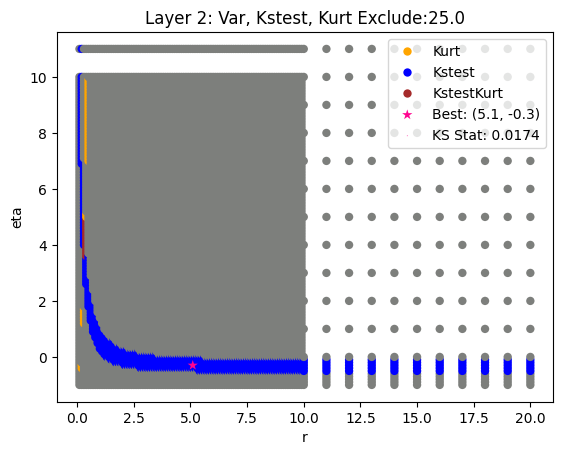

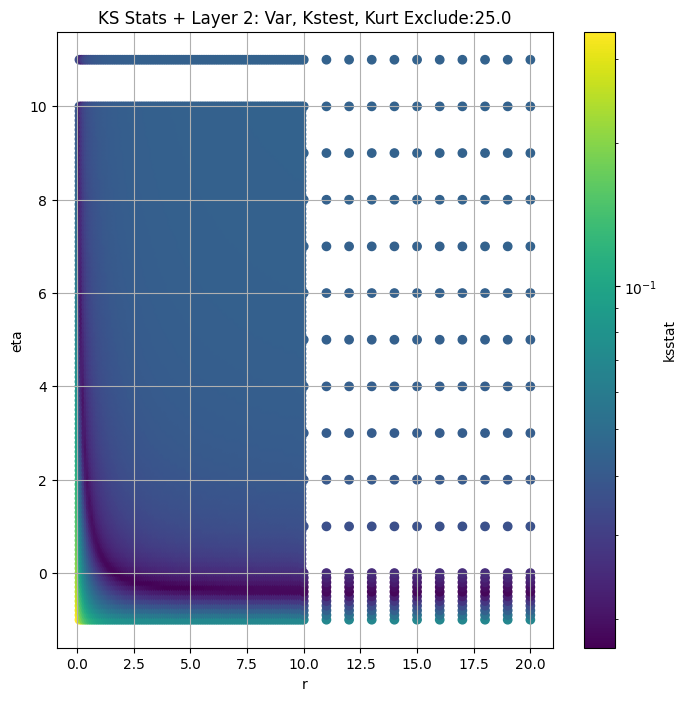

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.004247907741929513 731.8085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.006460092005946327 674.56726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.008688461917100154 641.0949


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.010745562235221384 613.55774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.012738587892491937 589.786


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.01647384838278554 548.8737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.020736917526505083 515.29285


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.02492929067518934 486.2541


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.029264350170117304 460.52155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.03330524341748986 437.8254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.04457267835972345 381.2212
Number of samples: 12720, Without approximation : 12720.0


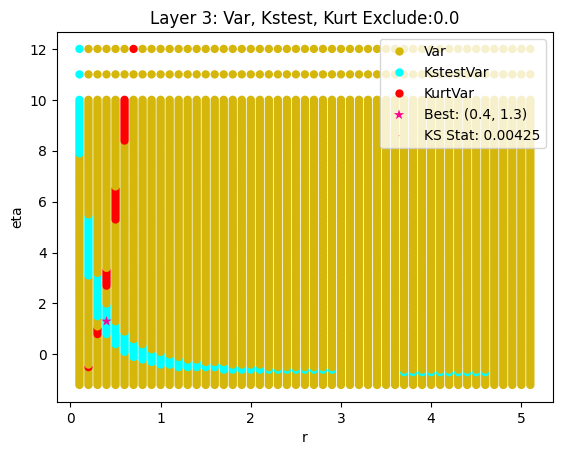

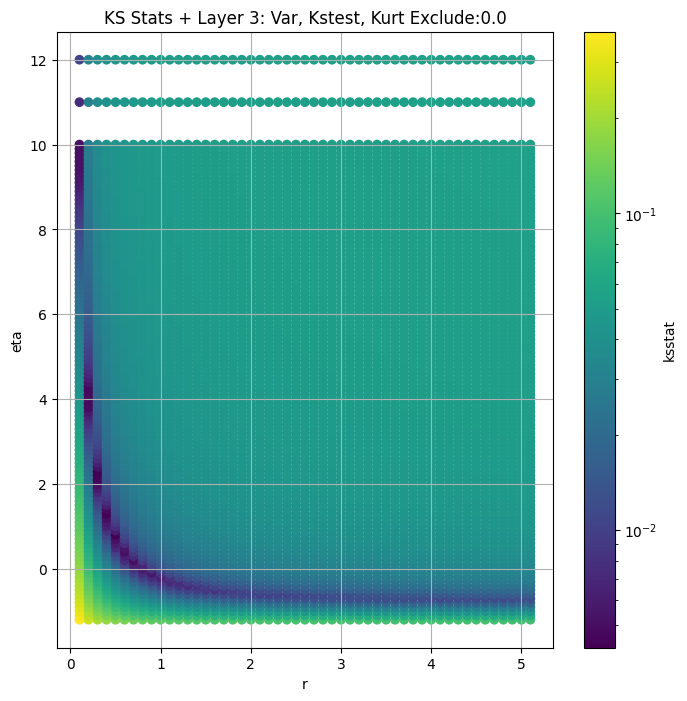

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.004979893614850239 204.85616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.005209272049004898 198.52371


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.005490412388710286 194.38759


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.0064391988876605355 190.82568


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.006325738198777131 187.64143


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.007070481304267906 181.95041


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.007904694611046259 177.03197


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.009197231407780615 172.5788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.010419098732971865 168.46611


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.011655067758213677 164.64742


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.014885078897716064 154.69508
Number of samples: 50880, Without approximation : 50880.0


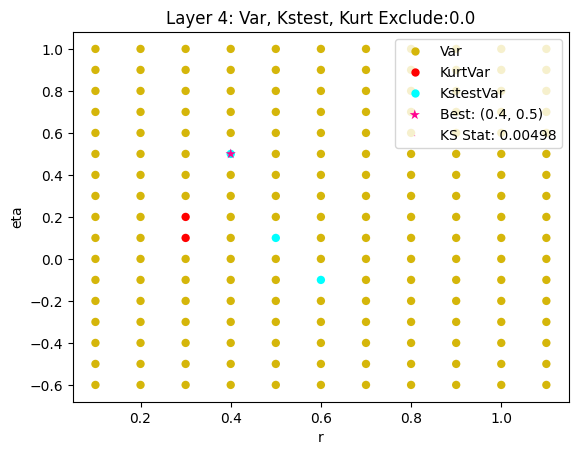

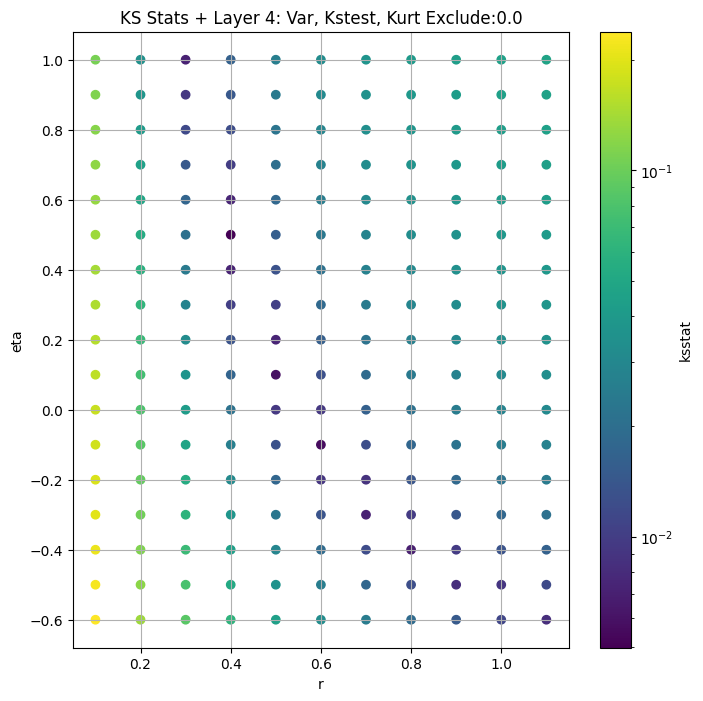

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0030227253665249254 47.32907


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.00259788593572996 46.2599


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.003372918044418416 45.499836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.003425277481967026 44.845467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.003906336722699466 44.26212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0042977377190766 43.243435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.004827647667668966 42.35104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.005541089113184738 41.55198


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0061437574102919945 40.814053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00666325646282051 40.1314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008389380829564197 38.30742
Number of samples: 100000, Without approximation : 203520.0


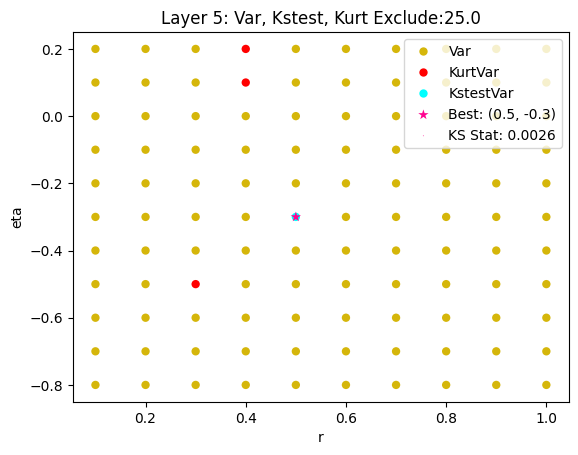

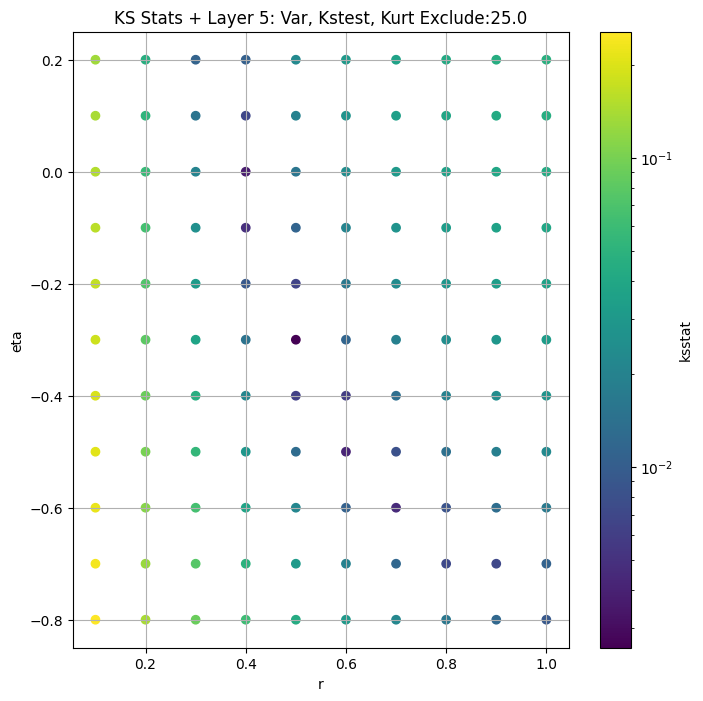

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.0038702677411548425 9.356699


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.004451915321864508 9.084558


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.003974624754783385 8.906506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.004909911163915259 8.755926


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.0053629147997033 8.621597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.006051381896059194 8.386519


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.006102017679663119 8.18227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.006968011055158374 7.998828


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.006704104828103685 7.8316336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.006945946892432553 7.67725


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.008533810435078615 7.272254
Number of samples: 100000, Without approximation : 814080.0


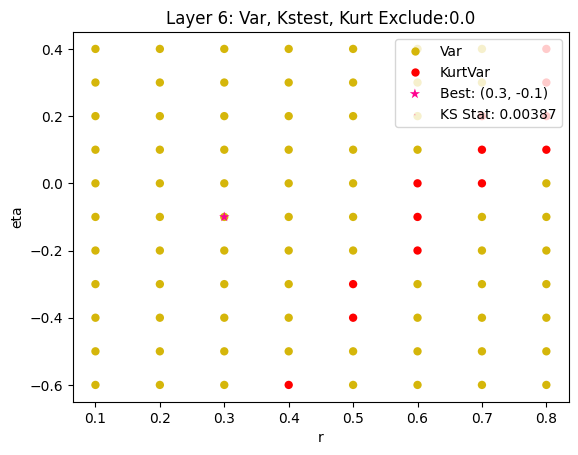

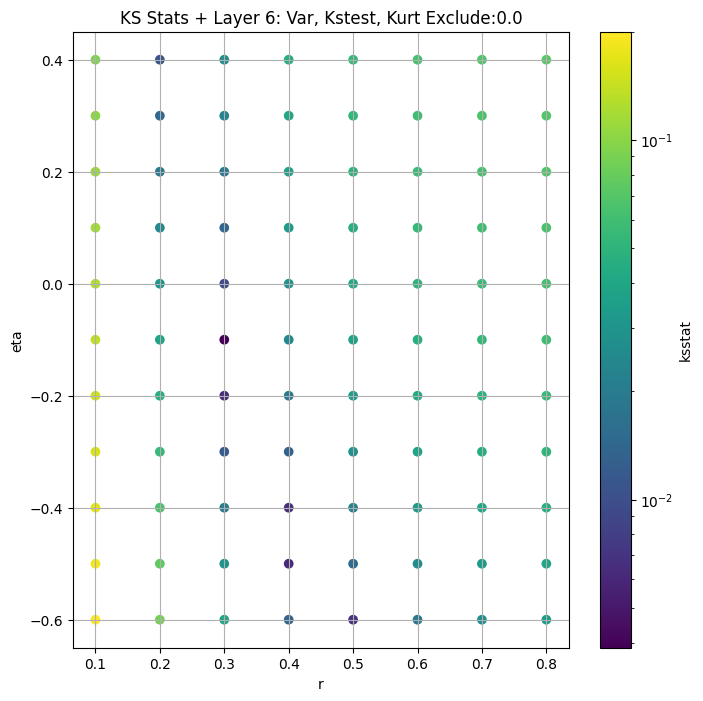

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.006717640472213016 1.7147584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.00520516530818893 1.656466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.0057617790391251145 1.6182104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.00684650756951255 1.5861356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.007847675201785087 1.5578403


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.006166847697859801 1.5085102


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.007437819749869901 1.4658631


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.008689597321293263 1.4277464


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.00788415850004498 1.3931239


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.007997849738275442 1.3612348


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.010422877289182952 1.2778444
Number of samples: 100000, Without approximation : 3256320.0


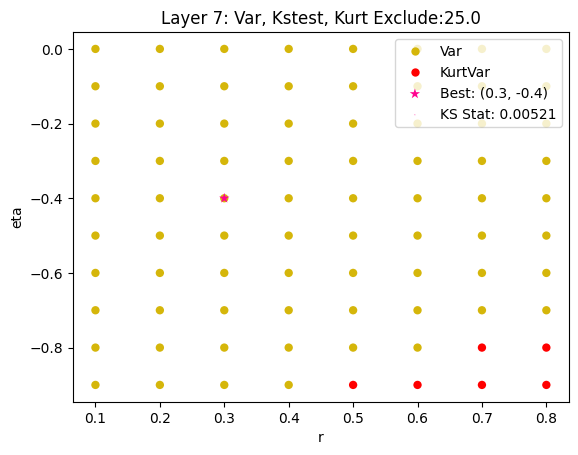

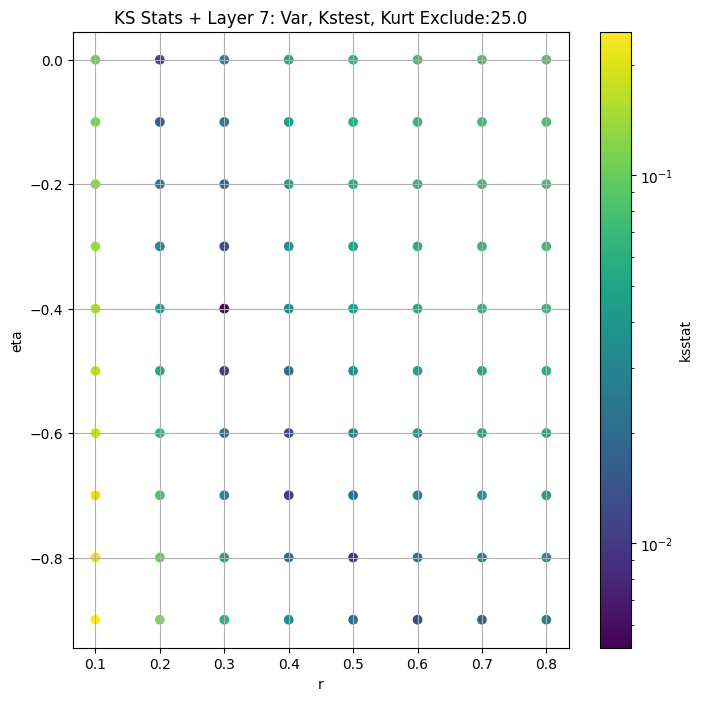

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.007074474293991551 0.26178214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006179524326670571 0.2506054


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.007044978924473089 0.24396323


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.00803354681176316 0.23847553


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0077702238588316375 0.23367575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.009323367852364428 0.22539689


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.008056080177088809 0.21827321


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.009236546931921219 0.21195212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.010410910810593865 0.20623958


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.009877618659529963 0.2010164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.012007710483080913 0.1874823
Number of samples: 100000, Without approximation : 13025280.0


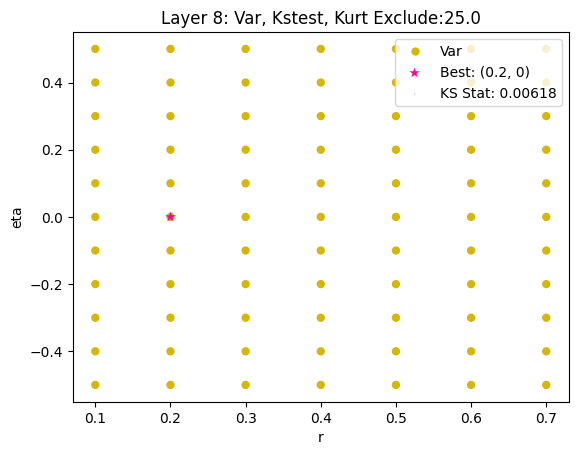

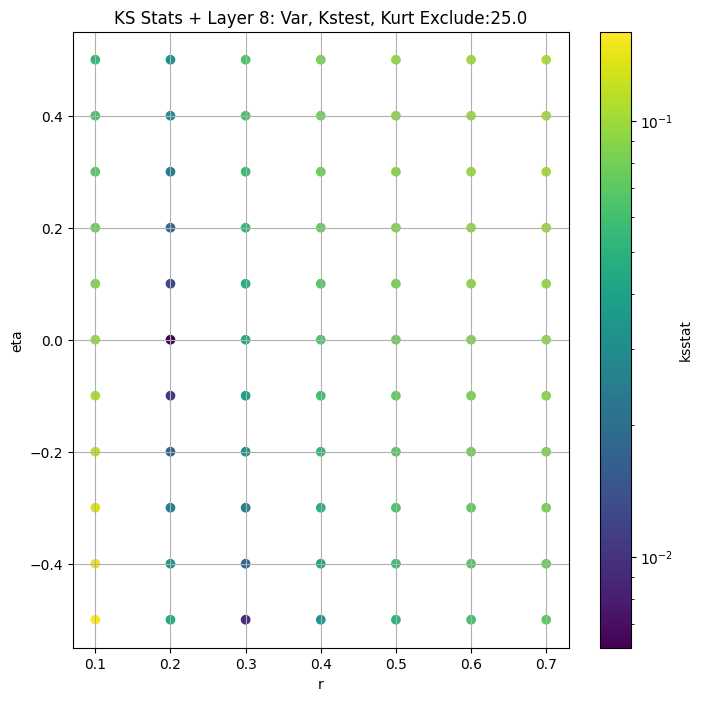

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2275.500700  2053.203900  2515.630100   2.985151    1.770765   
3       731.808500   692.460750   773.192600   2.677345    2.022238   
4       204.856160   192.844450   217.289660   3.331176    2.626189   
5        47.329070    44.213856    50.590443   4.919961    3.891603   
6         9.356699     8.643291    10.108271   7.053292    5.380576   
7         1.714758     1.571090     1.868863   9.429799    7.182782   
8         0.261782     0.237458     0.290044  13.011990    8.738512   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.367098         3180.0             0.017402        5.1         -0.3   
3        3.451370        12720.0             0.004248        0.4          1.3   
4        4.226743        50880.0             0.004980        0.4          0.5   
5        6.230281       203520.0             0.002598        0.5         -0.3   
6        9.599891       814080.0             0.003870        0.3         -0.1   
7       13.313757      3256320.0             0.005205        0.3         -0.4   
8       28.509798     13025280.0             0.006180        0.2          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        3411.362889                    25.0         1812.548200   
3           4.416893                     0.0          731.808500   
4           2.627408                     0.0          204.856160   
5           5.669105                    25.0           46.259900   
6           0.027312                     0.0            9.356699   
7           0.009231                    25.0            1.656466   
8           0.000003                    25.0            0.250605   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.024030  
3                     0.012029  
4                     0.006018  
5                     0.003010  
6                     0.001505  
7                     0.000753  
8                     0.000376

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.05412223657096804, var: 1180.5068359375


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.0451509199159944, var: 1289.3748779296875


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.036198254907306326, var: 1422.716552734375


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.026485082849067476, var: 1590.0672607421875


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.01733855722585753, var: 1812.5482177734375


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.02514456326848935, var: 2275.500732421875
Number of samples: 3180, Without approximation : 3180.0


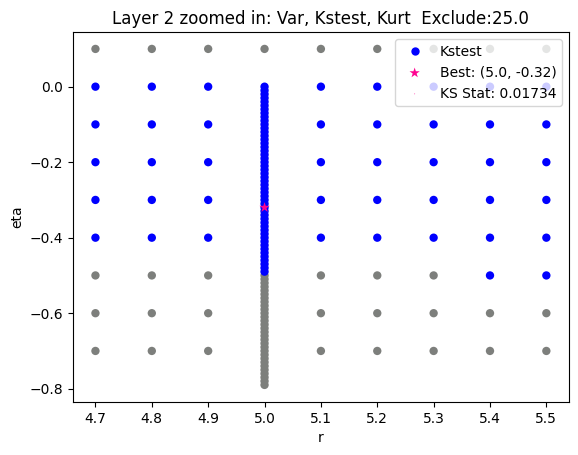

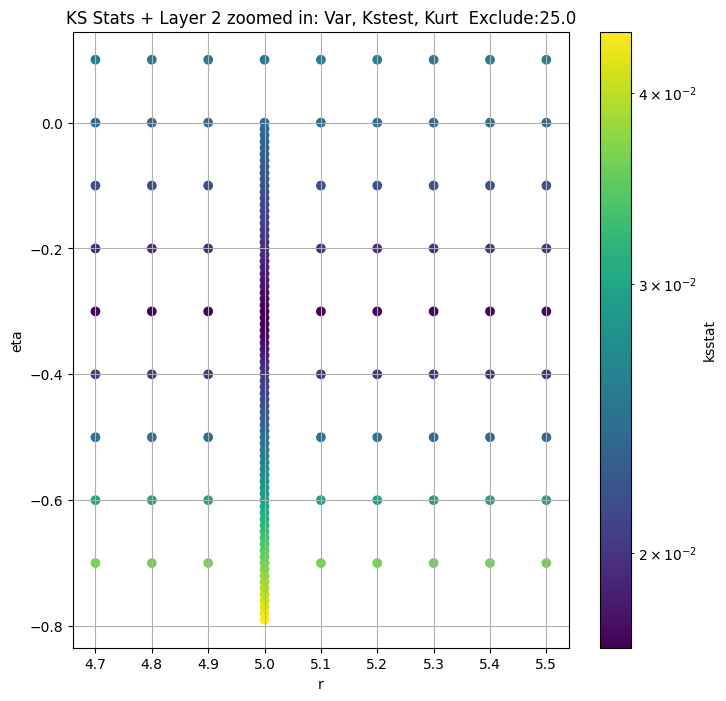

Layer 3


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.014824590503932256, var: 589.7860107421875


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.012620246747279129, var: 613.5577392578125


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.010330626925014963, var: 641.0949096679688


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.007718621526969338, var: 674.5672607421875


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.0041027161861172945, var: 731.8084716796875
Number of samples: 12720, Without approximation : 12720.0


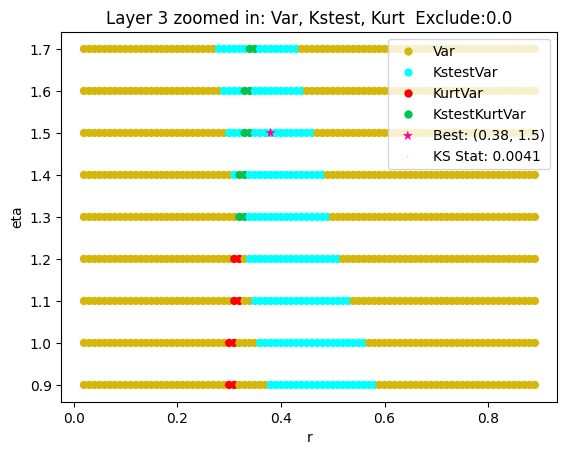

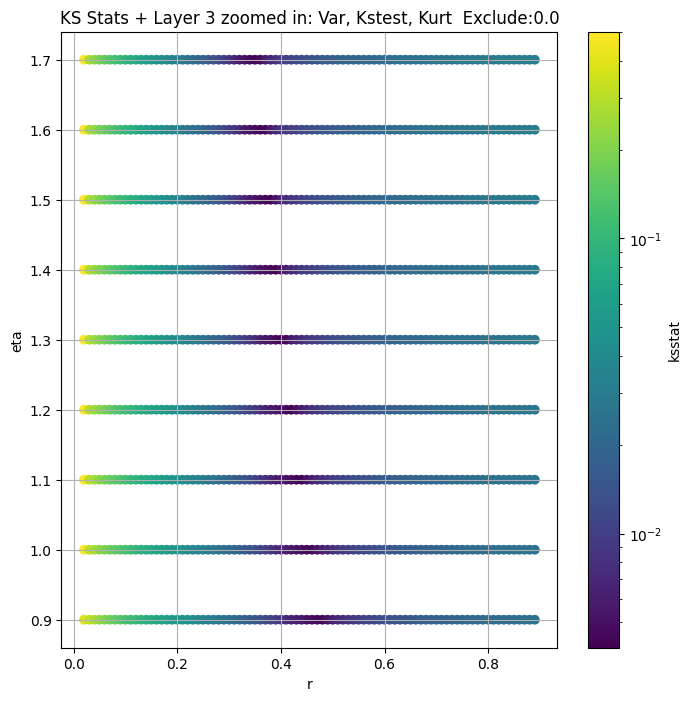

Layer 4


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.0073083231031225715, var: 187.6414337158203


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.006579909769746872, var: 190.82568359375


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.005801570901483699, var: 194.38758850097656


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.005209272049004898, var: 198.52371215820312


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.004937615631183112, var: 204.8561553955078
Number of samples: 50880, Without approximation : 50880.0


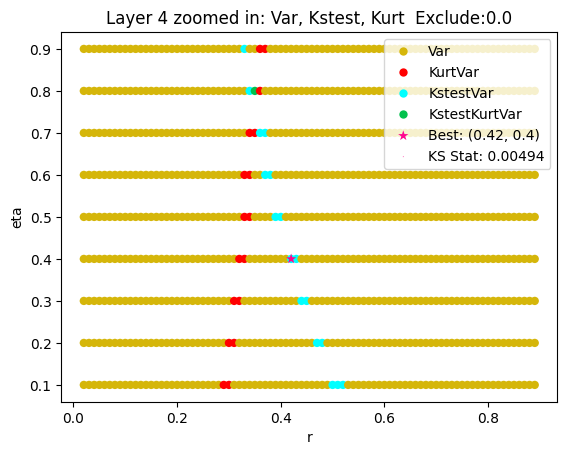

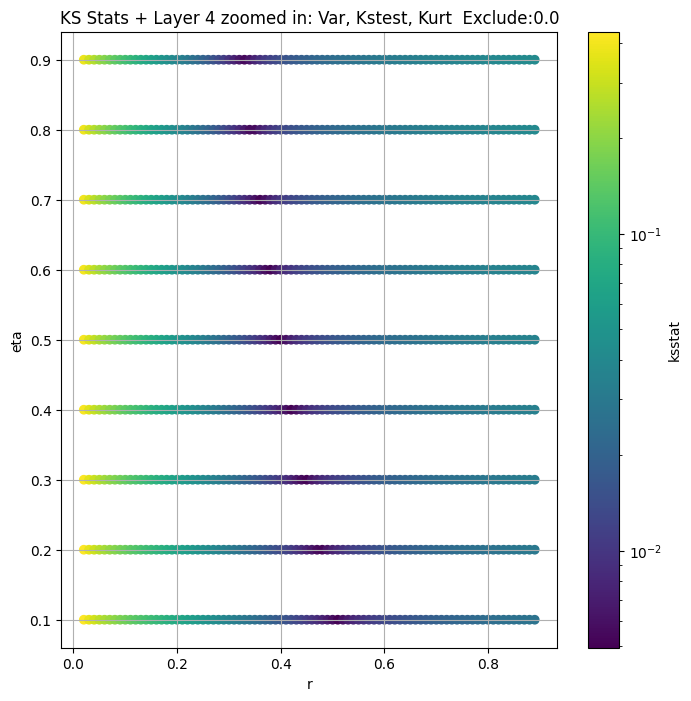

Layer 5


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 5, 25.0 + 100 = 125, ksstat: 0.003824993195485127, var: 43.732521057128906


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 5, 25.0 + 75 = 100, ksstat: 0.003434687483448995, var: 44.26211929321289


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 5, 25.0 + 50 = 75, ksstat: 0.0030729789596184443, var: 44.84546661376953


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 5, 25.0 + 25 = 50, ksstat: 0.002666759770033611, var: 45.49983596801758


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 5, 25.0 + 0 = 25, ksstat: 0.002320374743796094, var: 46.2598991394043


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 5, 25.0 + -25 = 0, ksstat: 0.0018513891632127577, var: 47.329071044921875
Number of samples: 100000, Without approximation : 203520.0


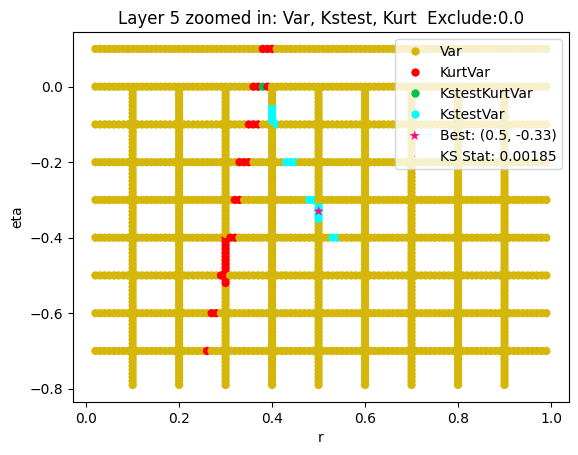

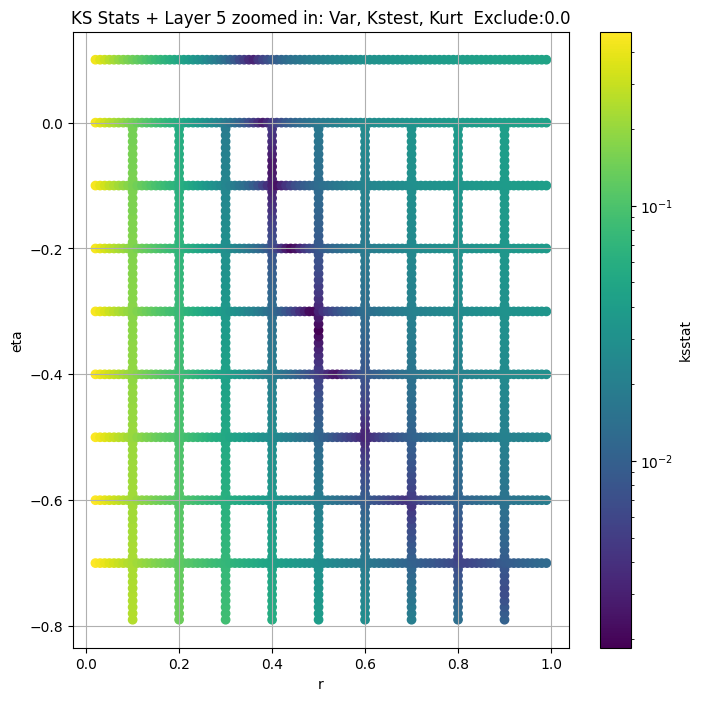

Layer 6


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.004145012313505281, var: 8.621597290039062


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.004030874012919128, var: 8.755926132202148


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.0038507192411155744, var: 8.906505584716797


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.0035008882080219683, var: 9.08455753326416


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.0032917765262272525, var: 9.356698989868164
Number of samples: 100000, Without approximation : 814080.0


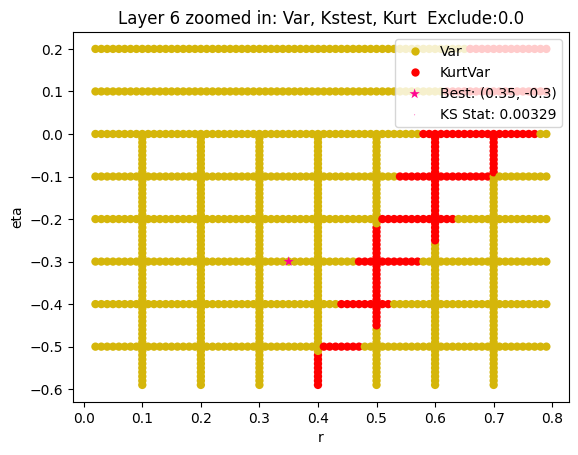

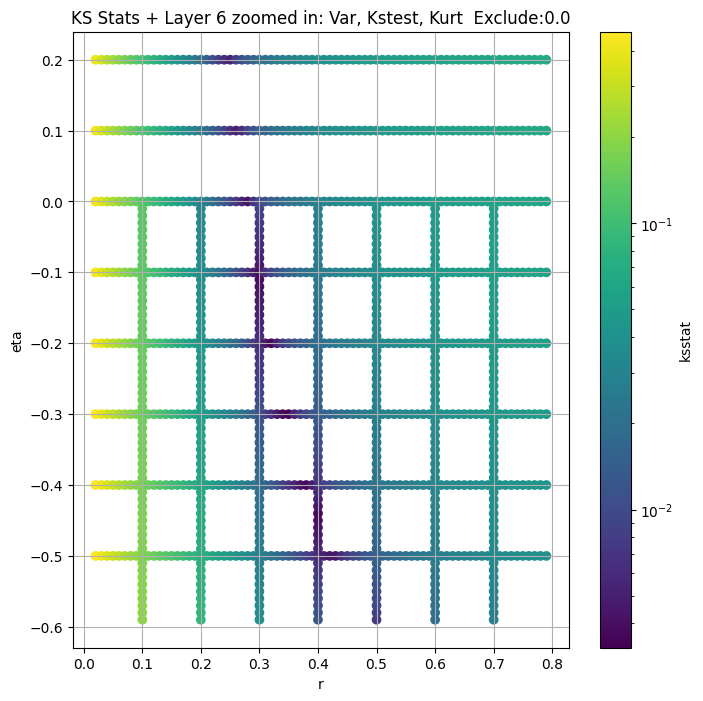

Layer 7


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.006061650257385809, var: 1.5321717262268066


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.0058165154764441285, var: 1.557840347290039


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.005729303881814085, var: 1.5861356258392334


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.005419567433010086, var: 1.6182104349136353


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.00520516530818893, var: 1.656466007232666


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.00502140334736656, var: 1.7147583961486816
Number of samples: 100000, Without approximation : 3256320.0


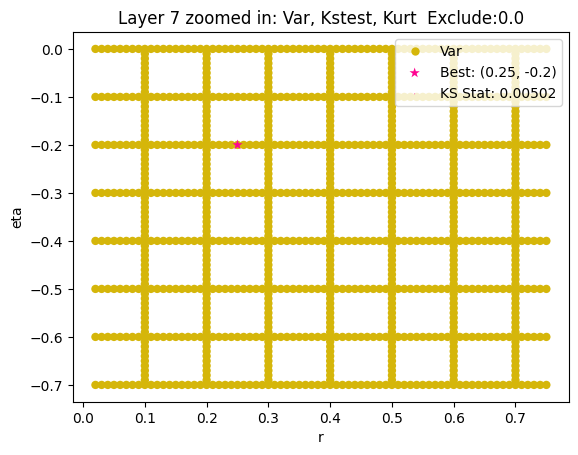

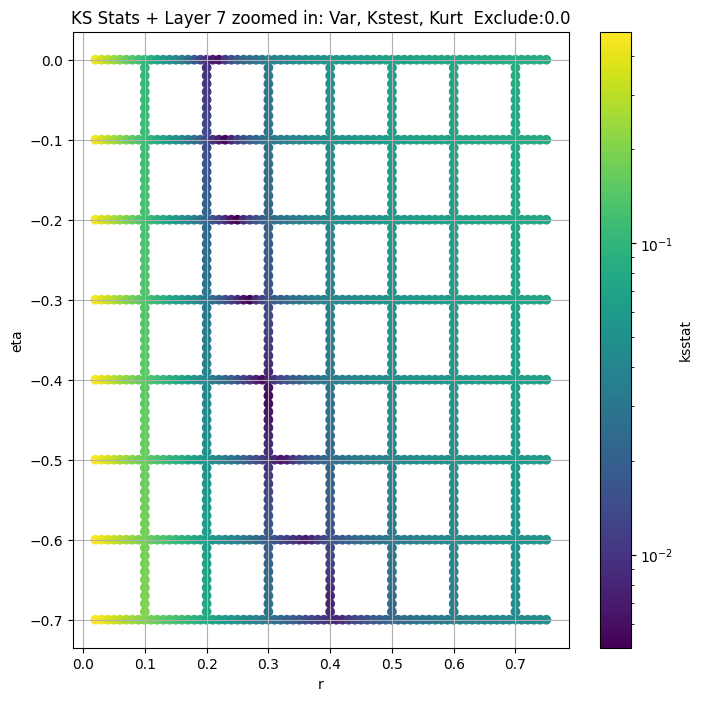

Layer 8


  0%|          | 0/936 [00:00<?, ?it/s]

Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.007439409468275149, var: 0.2293621301651001


  0%|          | 0/936 [00:00<?, ?it/s]

Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.007031657126374546, var: 0.2336757481098175


  0%|          | 0/936 [00:00<?, ?it/s]

Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.006979834160270704, var: 0.23847553133964539


  0%|          | 0/936 [00:00<?, ?it/s]

Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.007044978924473089, var: 0.24396322667598724


  0%|          | 0/936 [00:00<?, ?it/s]

Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.006169557728194386, var: 0.25060540437698364


  0%|          | 0/936 [00:00<?, ?it/s]

Finding Minimum after computing 936 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.0066050792426926574, var: 0.26178213953971863
Number of samples: 100000, Without approximation : 13025280.0


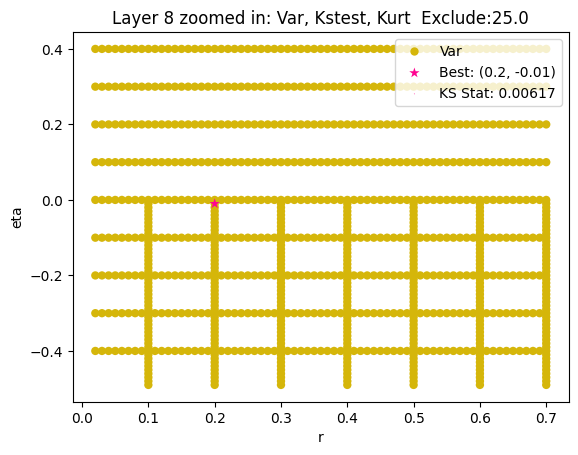

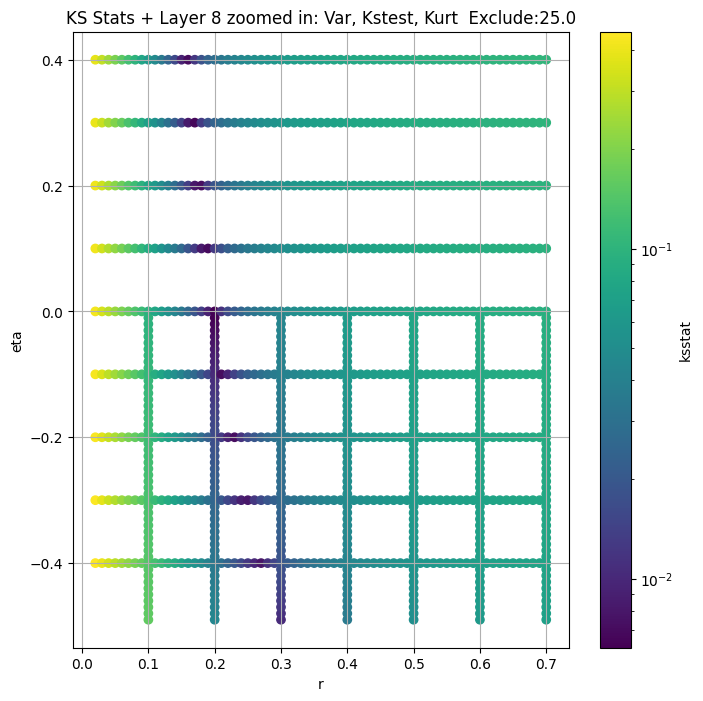

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2275.500700  2053.203900  2515.630100   2.985151    1.770765   
3       731.808500   692.460750   773.192600   2.677345    2.022238   
4       204.856160   192.844450   217.289660   3.331176    2.626189   
5        47.329070    44.213856    50.590443   4.919961    3.891603   
6         9.356699     8.643291    10.108271   7.053292    5.380576   
7         1.714758     1.571090     1.868863   9.429799    7.182782   
8         0.261782     0.237458     0.290044  13.011990    8.738512   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.367098         3180.0             0.017402        5.1         -0.3   
3        3.451370        12720.0             0.004248        0.4          1.3   
4        4.226743        50880.0             0.004980        0.4          0.5   
5        6.230281       203520.0             0.002598        0.5         -0.3   
6        9.599891       814080.0             0.003870        0.3         -0.1   
7       13.313757      3256320.0             0.005205        0.3         -0.4   
8       28.509798     13025280.0             0.006180        0.2          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        3411.362889                    25.0         1812.548218   
3           4.416893                     0.0          731.808472   
4           2.627408                     0.0          204.856155   
5           5.669105                    25.0           47.329071   
6           0.027312                     0.0            9.356699   
7           0.009231                    25.0            1.714758   
8           0.000003                    25.0            0.250605   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.024030          0.017339    5.00     -0.32   
3                     0.012029          0.004103    0.38      1.50   
4                     0.006018          0.004938    0.42      0.40   
5                     0.003010          0.001851    0.50     -0.33   
6                     0.001505          0.003292    0.35     -0.30   
7                     0.000753          0.005021    0.25     -0.20   
8                     0.000376          0.006170    0.20     -0.01   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      3437.486394                 25.0         6034  
3         2.479318                  0.0       108666  
4         4.086107                  0.0        76320  
5         6.055718                  0.0       515160  
6         0.146151                  0.0       171720  
7         0.000901                  0.0        76320  
8         0.000004                 25.0        50880

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

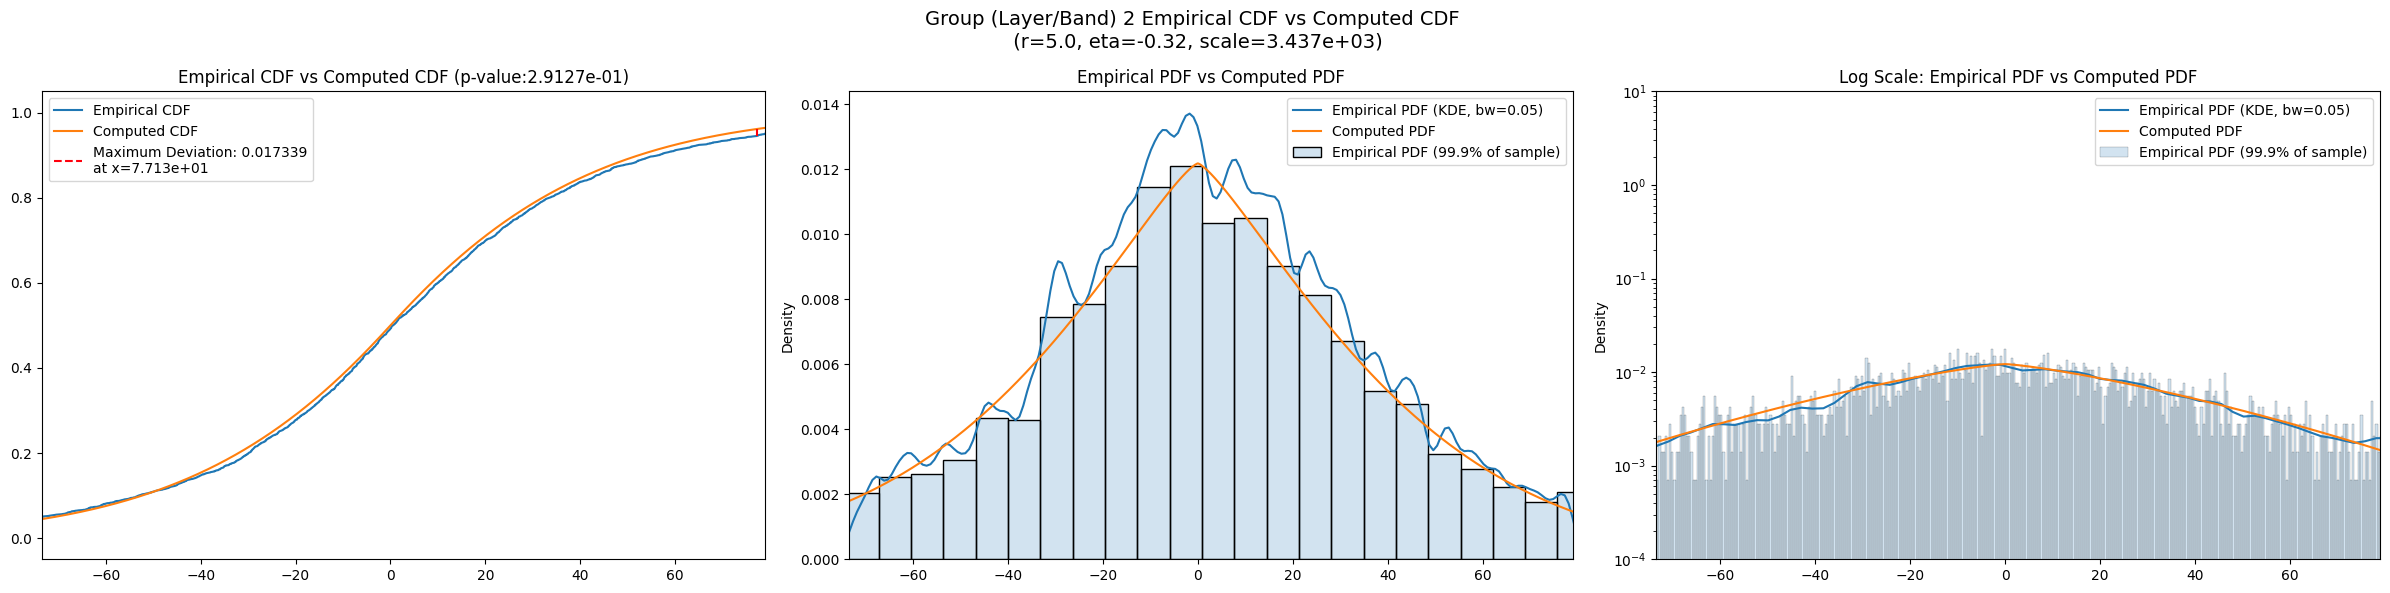

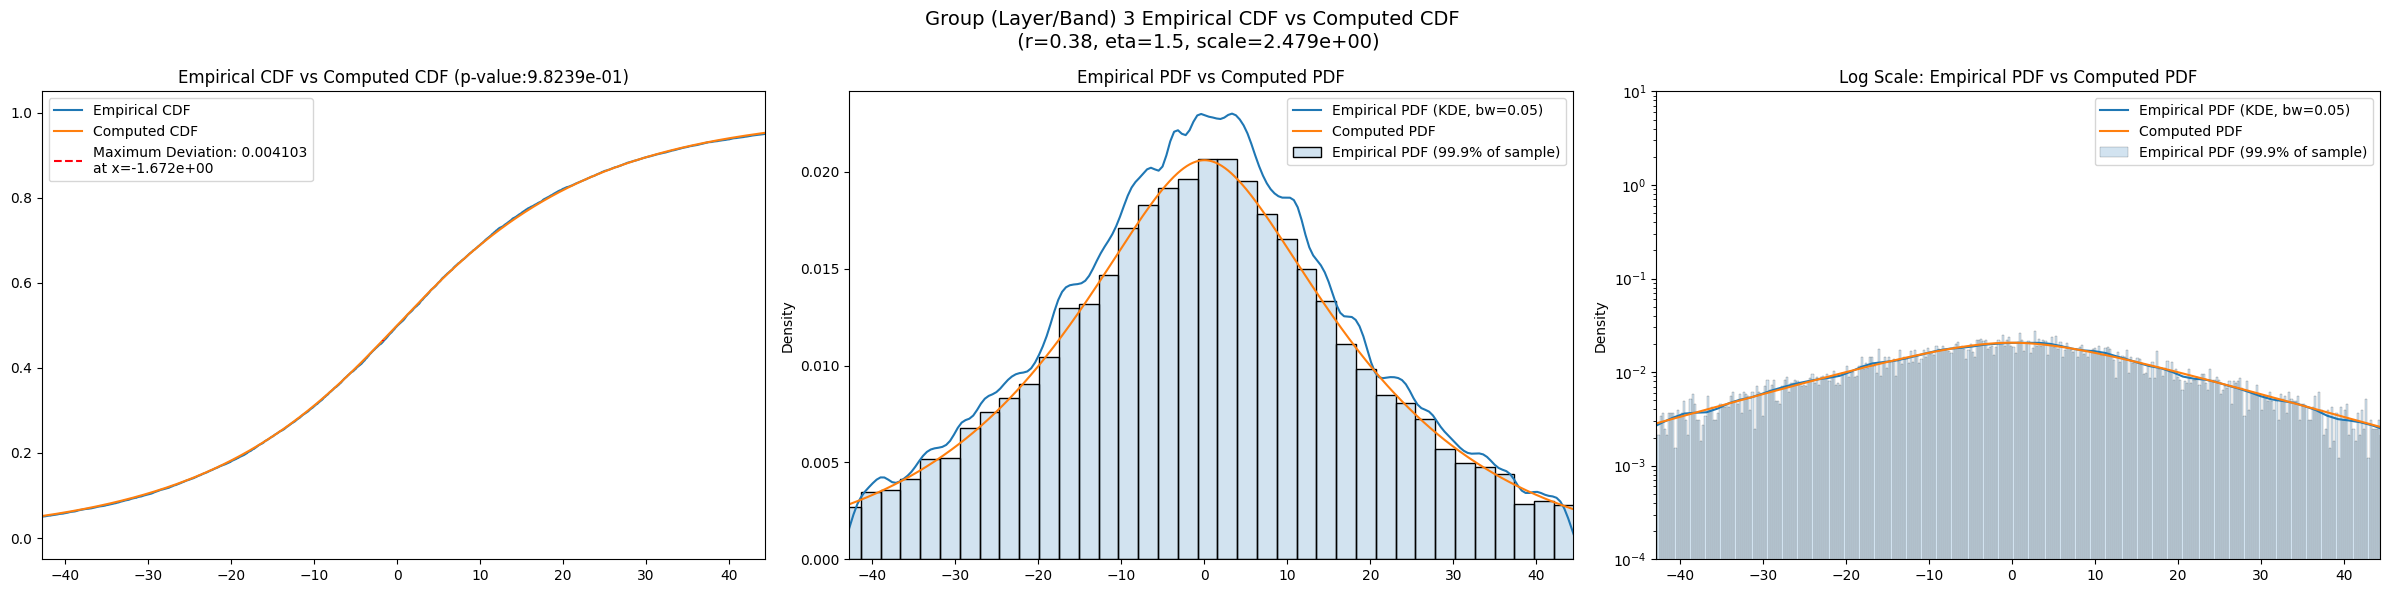

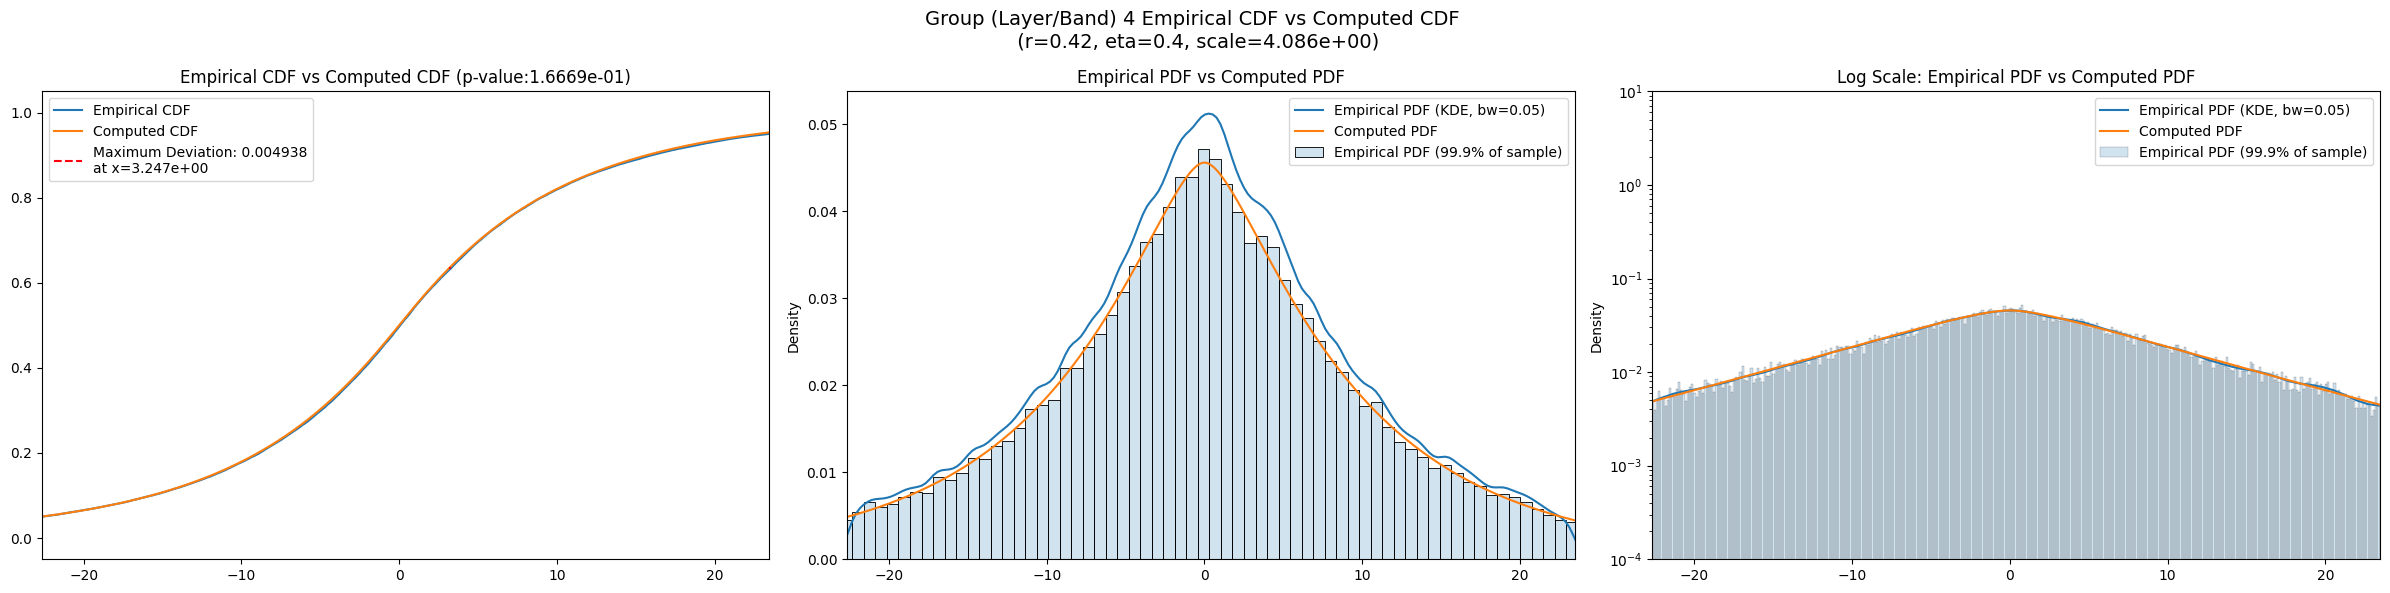

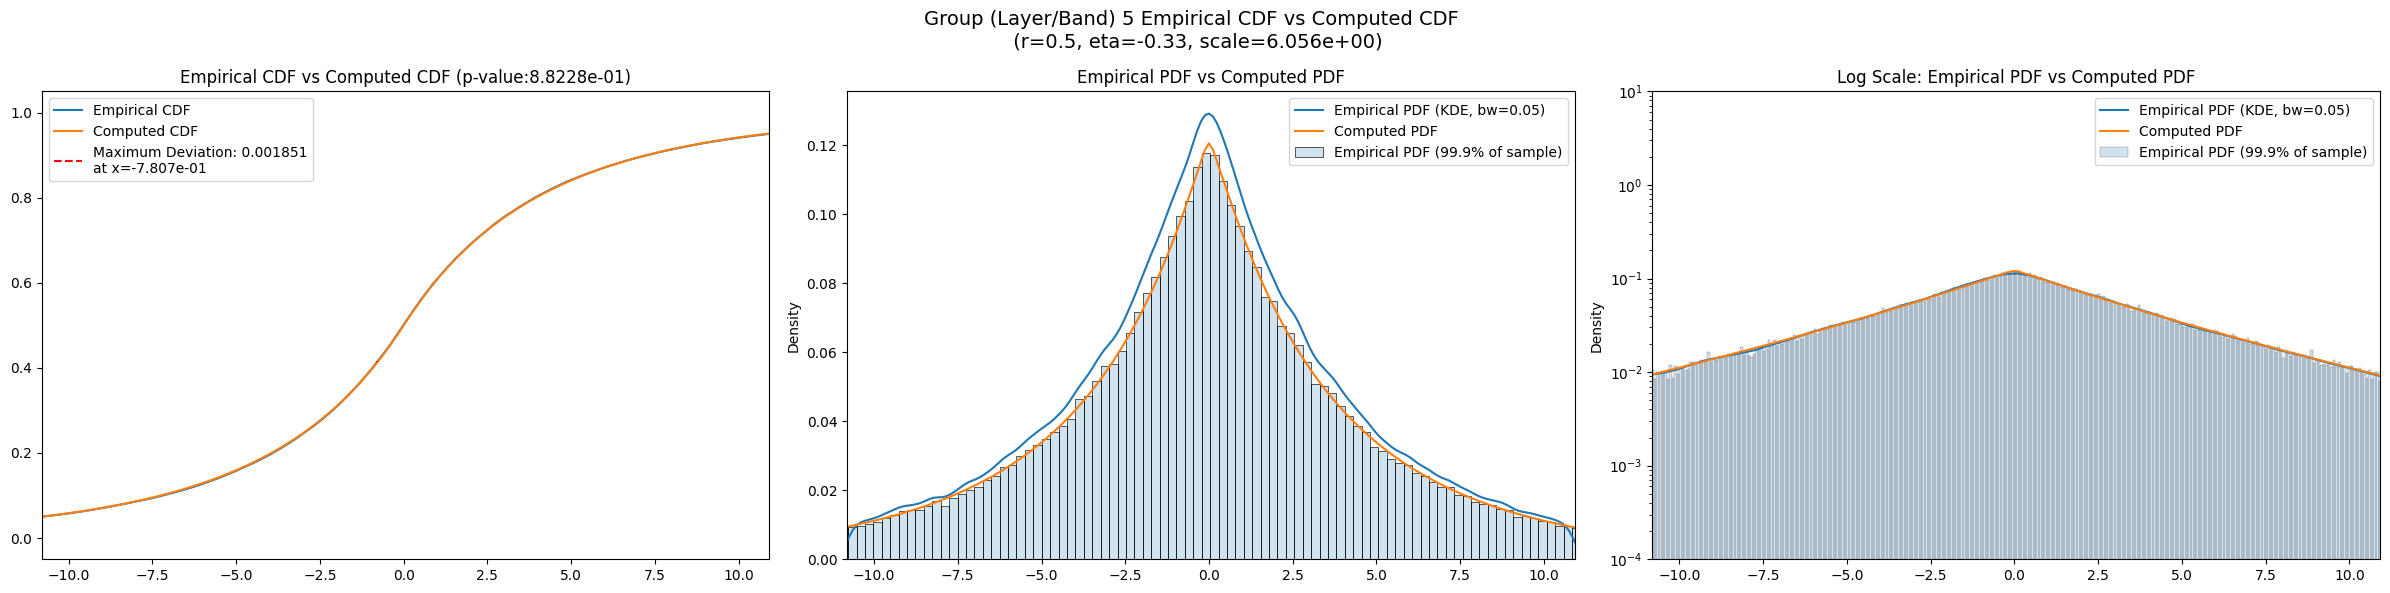

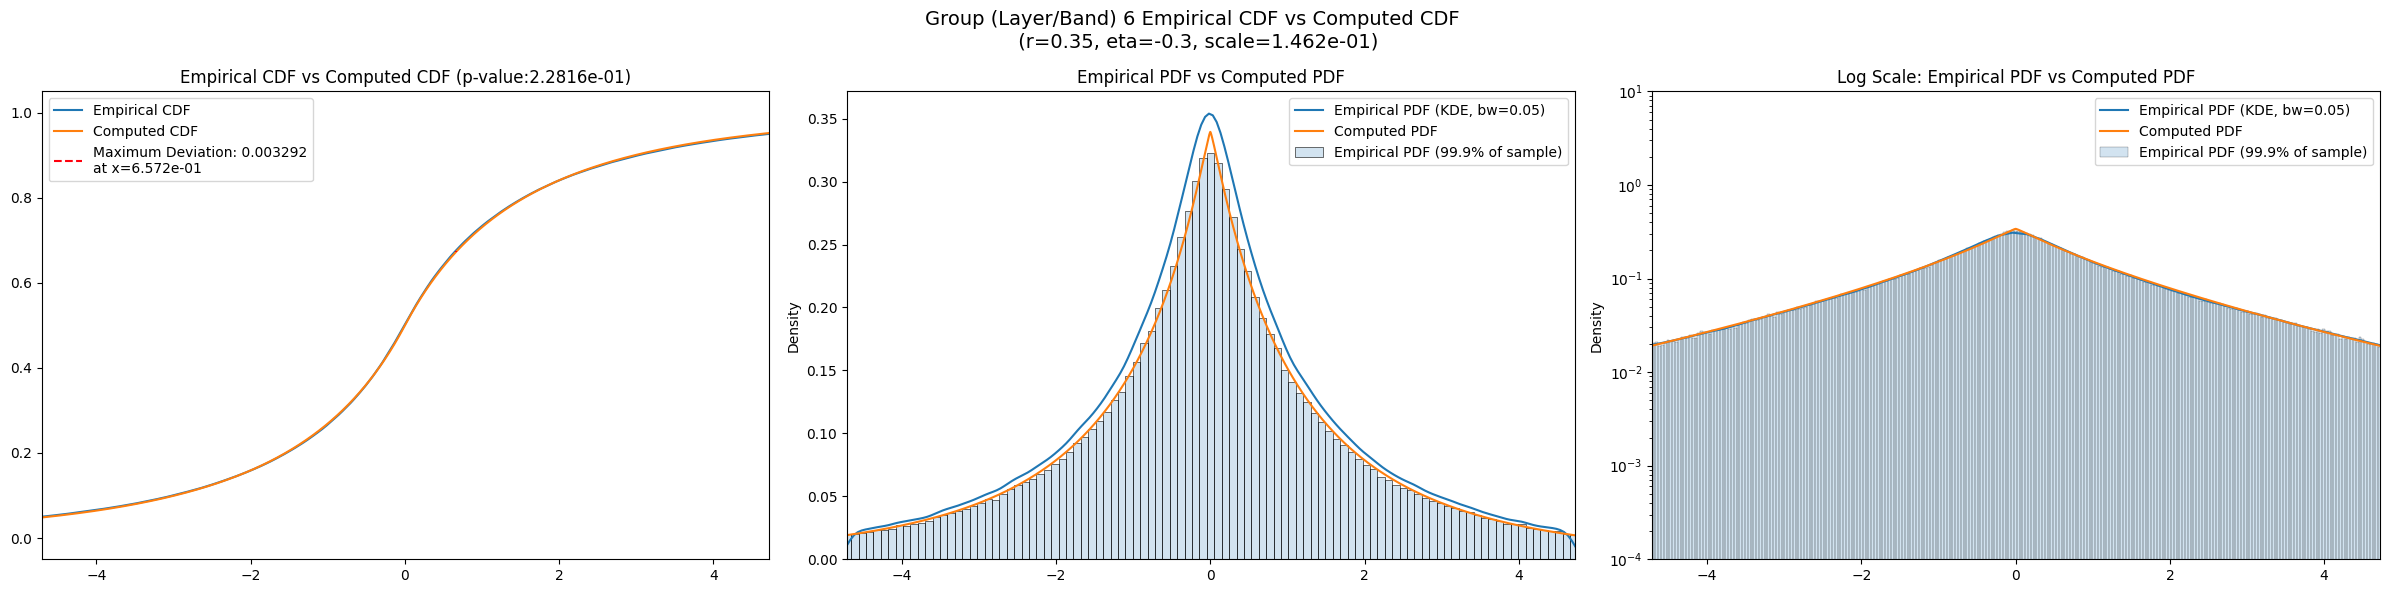

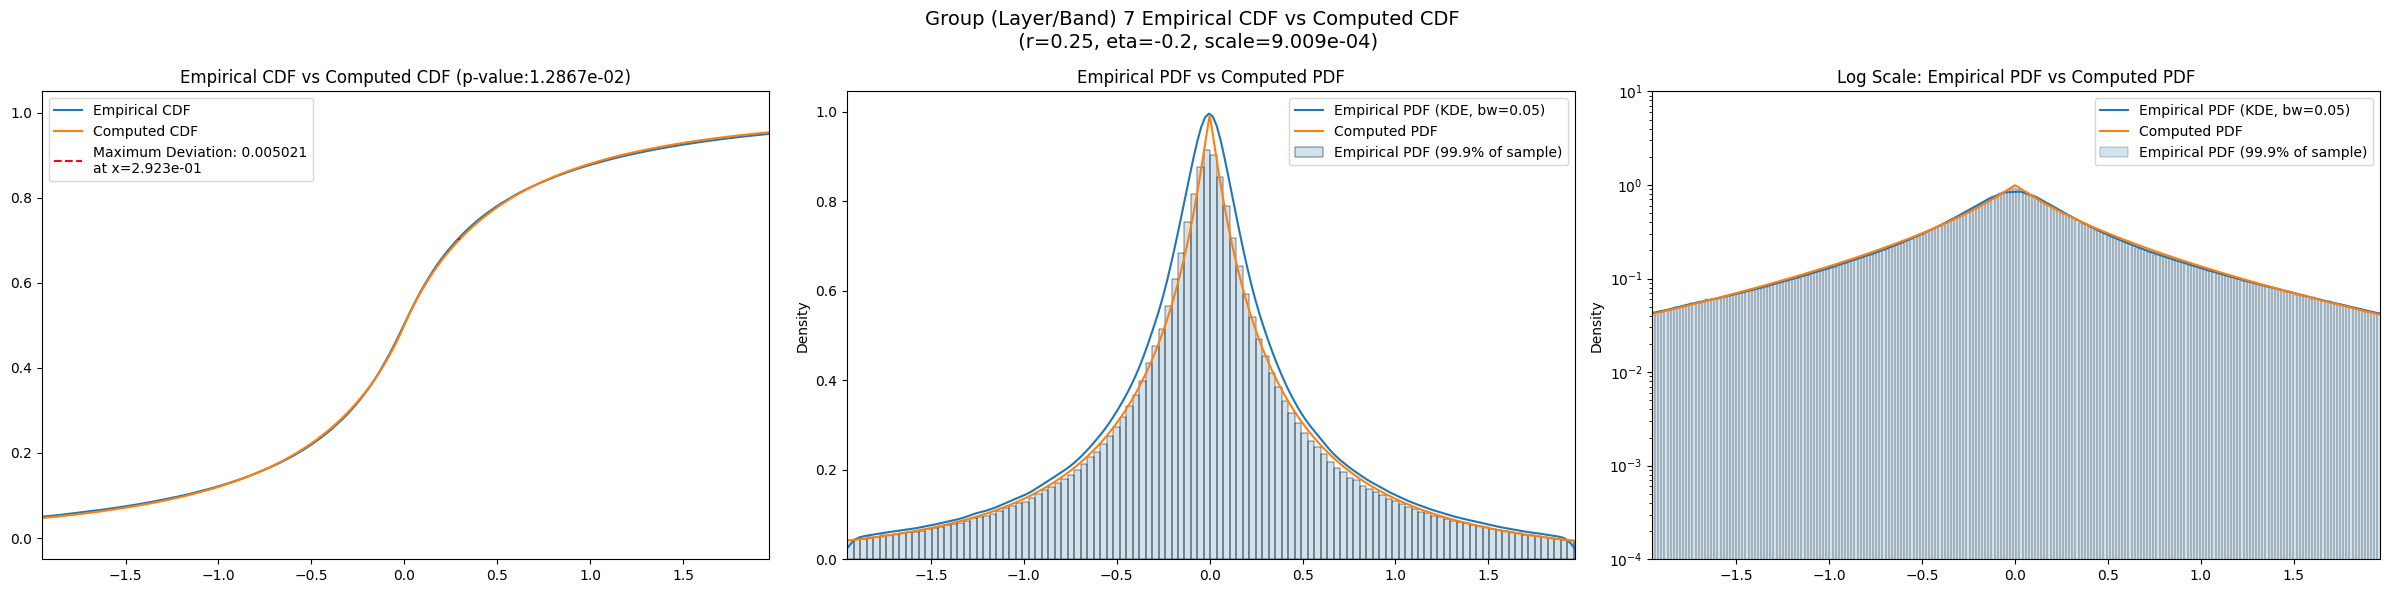

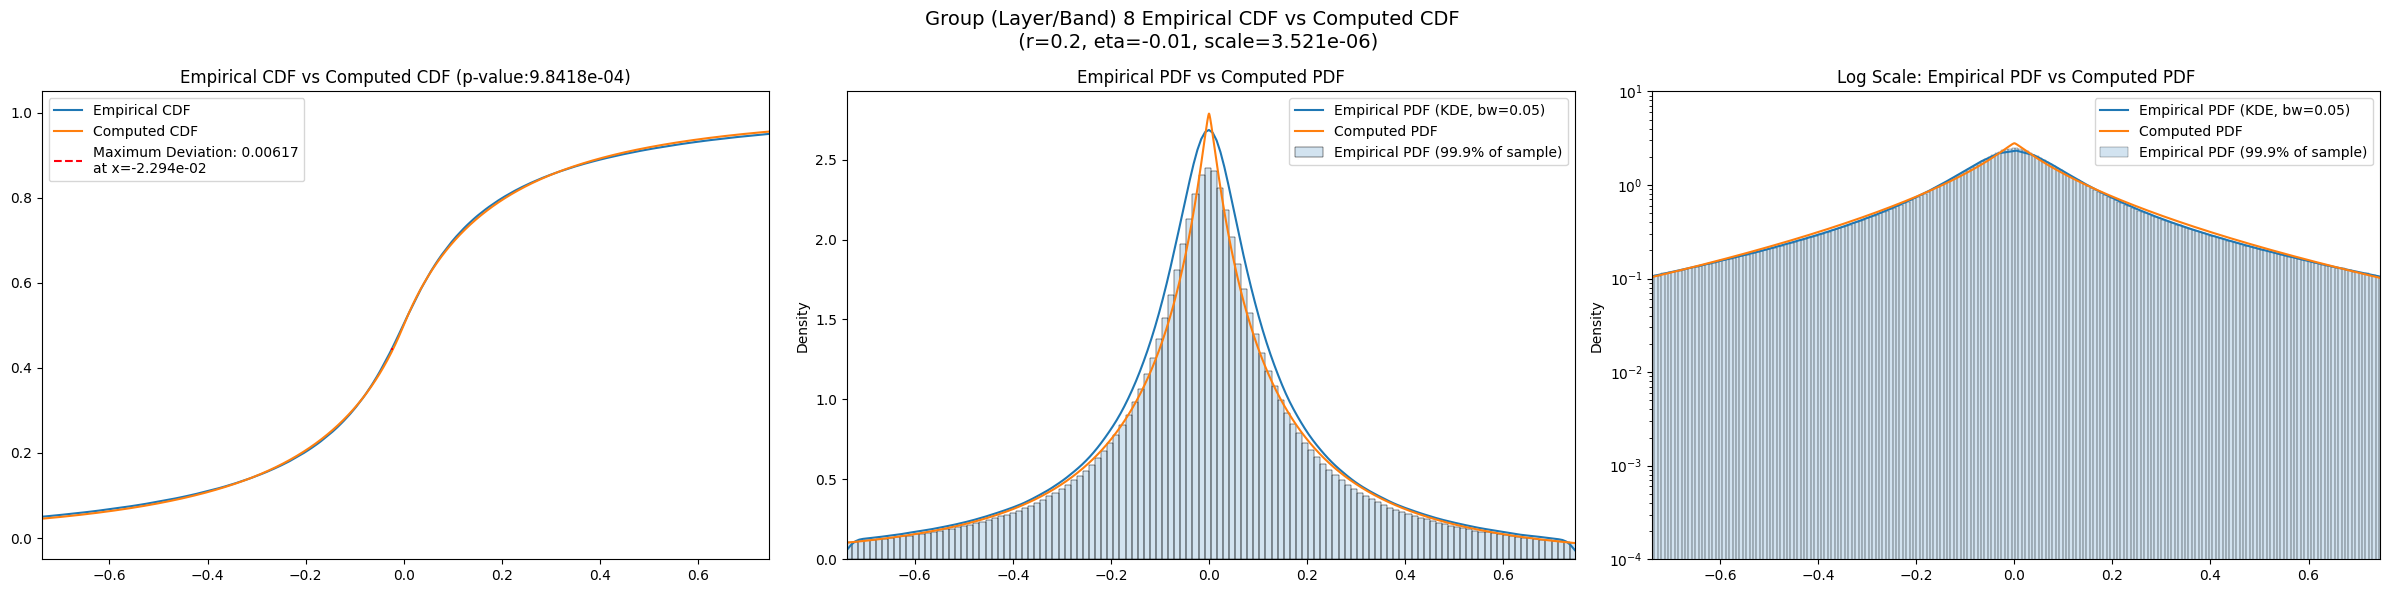

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2275.500700  2053.203900  2515.630100   2.985151    1.770765   
3       731.808500   692.460750   773.192600   2.677345    2.022238   
4       204.856160   192.844450   217.289660   3.331176    2.626189   
5        47.329070    44.213856    50.590443   4.919961    3.891603   
6         9.356699     8.643291    10.108271   7.053292    5.380576   
7         1.714758     1.571090     1.868863   9.429799    7.182782   
8         0.261782     0.237458     0.290044  13.011990    8.738512   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.367098         3180.0             0.017402        5.1         -0.3   
3        3.451370        12720.0             0.004248        0.4          1.3   
4        4.226743        50880.0             0.004980        0.4          0.5   
5        6.230281       203520.0             0.002598        0.5         -0.3   
6        9.599891       814080.0             0.003870        0.3         -0.1   
7       13.313757      3256320.0             0.005205        0.3         -0.4   
8       28.509798     13025280.0             0.006180        0.2          0.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       39.295100              0.031279          3.882720e-03   
3      ...       23.011700              0.024561          4.247500e-07   
4      ...       11.325000              0.031550          1.961370e-44   
5      ...        5.023220              0.036441         2.939090e-235   
6      ...        1.984590              0.045207          0.000000e+00   
7      ...        0.749247              0.053091          0.000000e+00   
8      ...        0.272328              0.055538          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          36.106400             0.023470         5.925120e-02  30.185700   
3          20.210500             0.011124         8.524380e-02  16.202400   
4           9.984210             0.006536         2.576780e-02   8.133190   
5           4.405080             0.008854         2.758160e-14   3.577390   
6           1.738220             0.017514        2.468270e-217   1.398520   
7           0.657265             0.025691         0.000000e+00   0.523662   
8           0.240091             0.028480         0.000000e+00   0.190437   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.019118   1.929850e-01          2.912703e-01  
3           0.013603   1.788420e-02          9.823906e-01  
4           0.010001   7.539610e-05          1.666864e-01  
5           0.011905   1.746710e-25          4.874669e-01  
6           0.019498  2.854520e-269          4.345720e-08  
7           0.026210   0.000000e+00          9.612072e-72  
8           0.026983   0.000000e+00          0.000000e+00  

[7 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.017402                 0.024030          0.017339   
3                 0.004248                 0.012029          0.004103   
4                 0.004980                 0.006018          0.004938   
5                 0.002598                 0.003010          0.001851   
6                 0.003870                 0.001505          0.003292   
7                 0.005205                 0.000753          0.005021   
8                 0.006180                 0.000376          0.006170   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.031279             0.023470       0.019118  
3                  0.024561             0.011124       0.013603  
4                  0.031550             0.006536       0.010001  
5                  0.036441             0.008854       0.011905  
6                  0.045207             0.017514       0.019498  
7                  0.053091             0.025691       0.026210  
8                  0.055538             0.028480       0.026983

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             1812.548218          0.017339    5.00     -0.32  3437.486394   
3              731.808472          0.004103    0.38      1.50     2.479318   
4              204.856155          0.004938    0.42      0.40     4.086107   
5               47.329071          0.001851    0.50     -0.33     6.055718   
6                9.356699          0.003292    0.35     -0.30     0.146151   
7                1.714758          0.005021    0.25     -0.20     0.000901   
8                0.250605          0.006170    0.20     -0.01     0.000004   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                     25.0